<a href="https://colab.research.google.com/github/JosherenPro/Computer-Vision-Dog-vs-Cat/blob/main/computer_vision_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Link to
> ### https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification?select=train

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving train.zip to train (1).zip
Saving test.zip to test (1).zip


In [ ]:
from zipfile import ZipFile
import time

train_zip = "train.zip"
test_zip = 'test.zip'

def timer(func):
  def wrapper(*args, **kwargs):
    start = time.time()
    func(*args, **kwargs)
    end = time.time()
    print(f"Time for unzip {args}: {end - start}")
  return wrapper

@timer
def extract_zip(zip_file):
  with ZipFile(zip_file, 'r') as zip:
    zip.extractall(zip_file.split('.')[0])

extract_zip(train_zip)
extract_zip(test_zip)

Time for unzip ('train.zip',): 0.5363414287567139
Time for unzip ('test.zip',): 0.13793468475341797


In [ ]:
import shutil
import os

if os.path.exists('/content/train/__MACOSX') or os.path.exists('/content/test/__MACOSX'):
  shutil.rmtree('/content/train/__MACOSX')
  shutil.rmtree('/content/test/__MACOSX')

train_dir = '/content/train'
test_dir = '/content/test'

In [ ]:
img_height = 224
img_width = 224
batch_size = 32

In [97]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    seed = 123,
    subset = 'validation',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 557 files belonging to 2 classes.
Using 446 files for training.
Found 557 files belonging to 2 classes.
Using 111 files for validation.
Found 140 files belonging to 2 classes.
['cats', 'dogs']


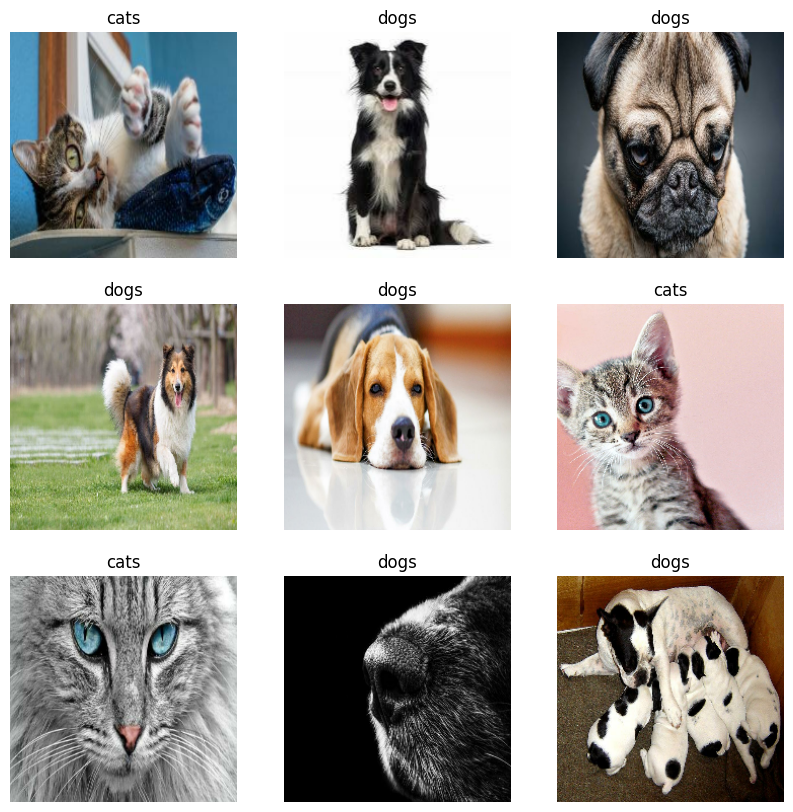

In [98]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

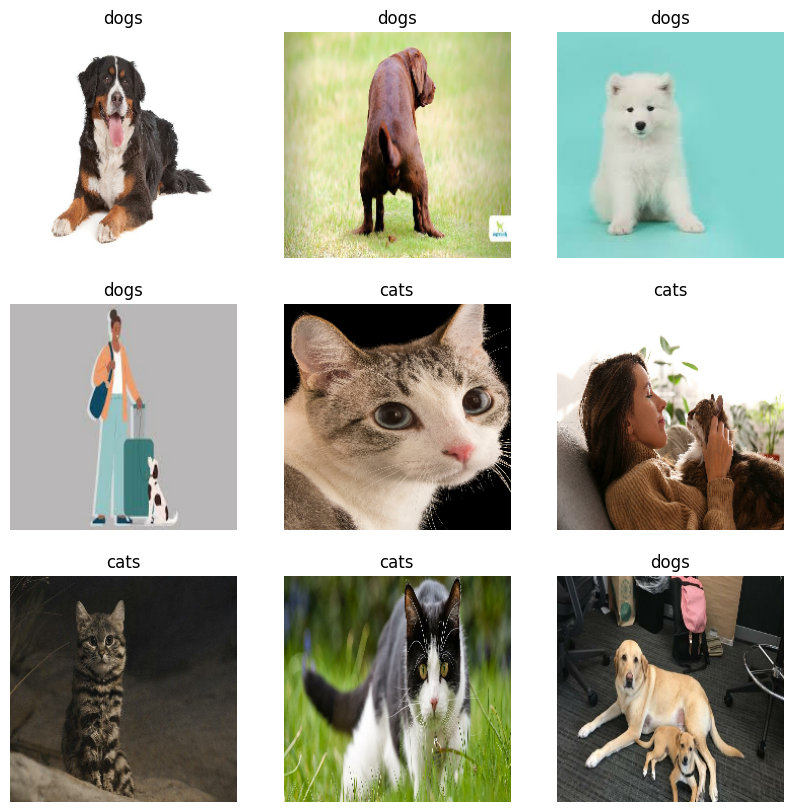

In [99]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

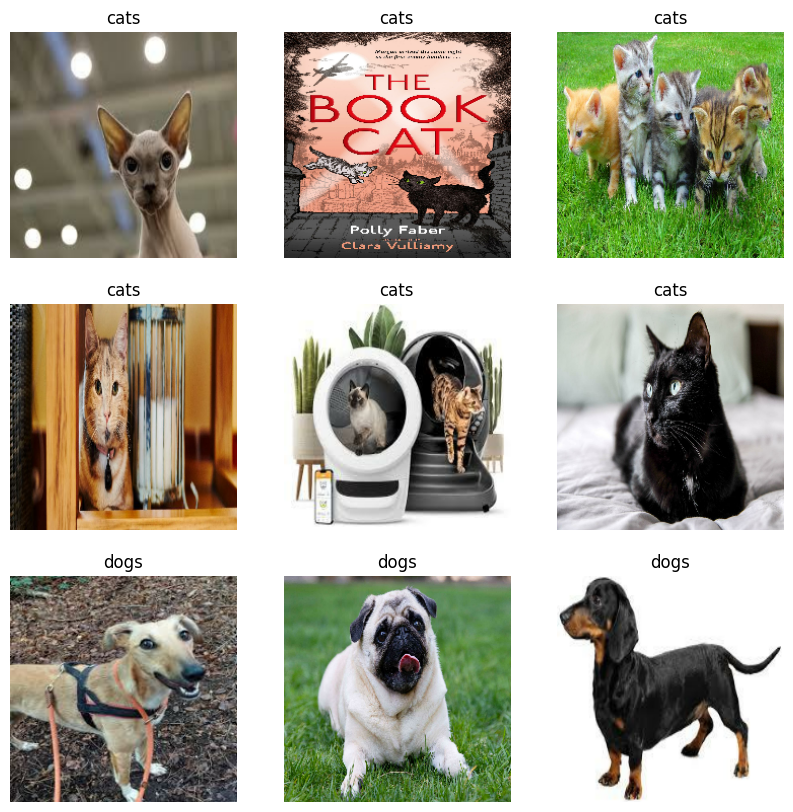

In [100]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(3):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [101]:
"""
→ Cache toutes les images après le premier passage.

→ Prépare en avance les batches suivants,
pendant que le GPU ou le CPU s'occupe de l'entraînement.
"""
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def preprocess_image(image, label):
  image = preprocess_input(image)
  return image, label

# Use AUTOTUNE to optimize training by allowing the TensorFlow dataset to dynamically adjust the buffer size
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# Cache the dataset to improve performance by loading the images into memory after the first epoch
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

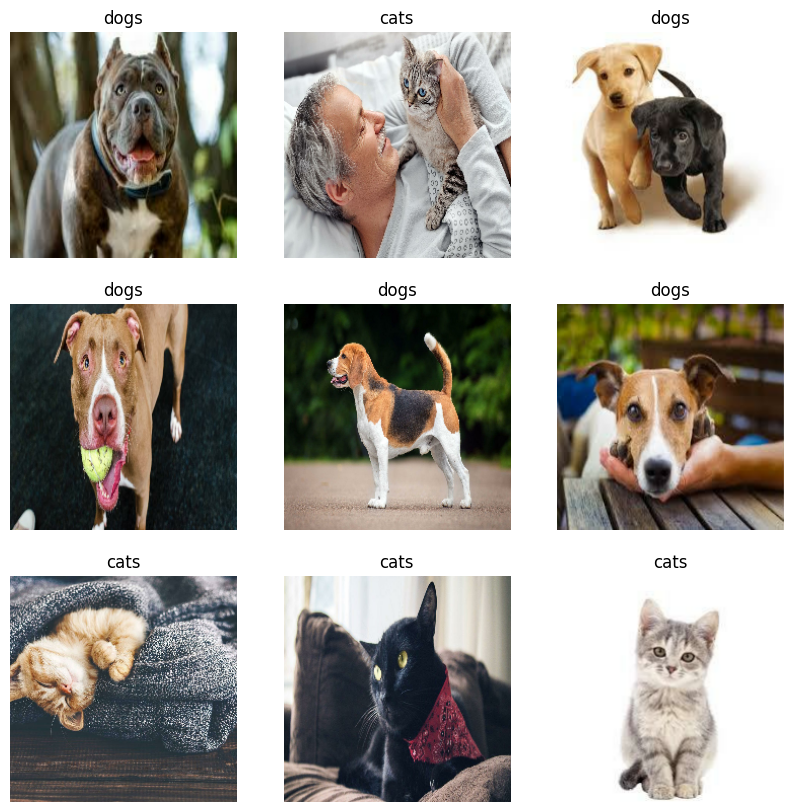

In [102]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [115]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2B0

pretrained_base = EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
)

pretrained_base.trainable = False

model = keras.Sequential([
    layers.InputLayer(shape=(img_height, img_width, 3)),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.5),
    layers.RandomSaturation(0.3),
    layers.RandomContrast(0.3),
    pretrained_base,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(1e-5)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [116]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_12 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_12              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_12 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_saturation_10            │ (None, 224, 224, 3)    │             0 │
│ (RandomSaturation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_10              │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,088,529 (23.23 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [125]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience = 10,
    restore_best_weights = True
)

In [126]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - binary_accuracy: 0.9455 - loss: 0.1337 - val_binary_accuracy: 0.9730 - val_loss: 0.0472
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - binary_accuracy: 0.9418 - loss: 0.1287 - val_binary_accuracy: 0.9820 - val_loss: 0.0480
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - binary_accuracy: 0.9532 - loss: 0.1259 - val_binary_accuracy: 0.9730 - val_loss: 0.0511
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - binary_accuracy: 0.9593 - loss: 0.1391 - val_binary_accuracy: 0.9730 - val_loss: 0.0646
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - binary_accuracy: 0.9528 - loss: 0.1324 - val_binary_accuracy: 0.9550 - val_loss: 0.0596
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - binary_accuracy: 0.9659 - loss: 0.0929 - val_binary_accuracy: 0.9550 - val_loss: 0.0657
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - binary_accuracy: 0.9414 - loss: 0.1296 - val_binary_accuracy: 0.9640 - val_loss: 0.0684
Epoch 8/50
1

<Axes: >

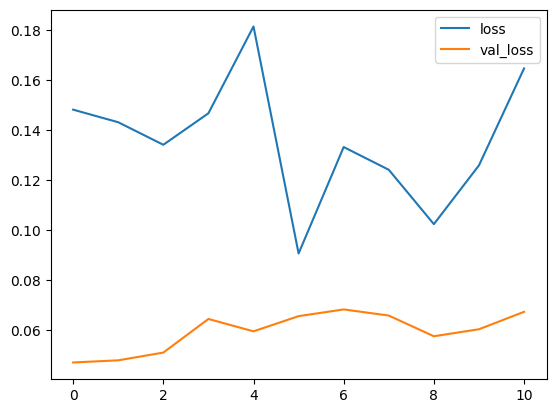

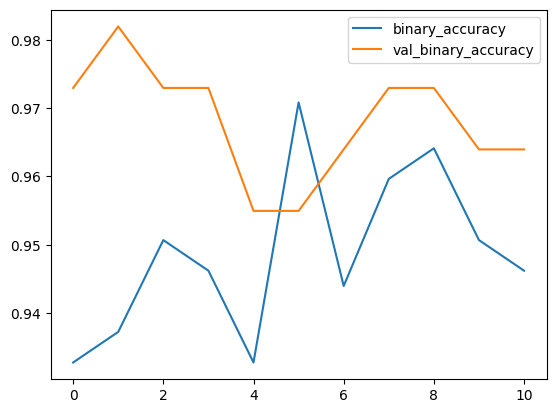

In [127]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot()
history_df[['binary_accuracy', 'val_binary_accuracy']].plot()

In [128]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - binary_accuracy: 0.9297 - loss: 0.1350
Loss: 0.12112895399332047
Accuracy: 0.9428571462631226
